## Birds and Frog species identification through deep learning

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import math
warnings.filterwarnings('ignore')
import os
import pandas as pd
!pip install librosa
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from IPython.core.display import HTML
from IPython.display import Audio
from scipy.io import wavfile
from IPython.display import Audio
import csv
import pickle
import joblib
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
os.chdir('/kaggle/input/rfcx-species-audio-detection/')
df = pd.read_csv('train_tp.csv') #Load the true positives

In [3]:
df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [4]:
df.describe()

,species_id,songtype_id,t_min,f_min,t_max,f_max
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,12.023849,1.315789,29.388748,2907.110280,31.925867,6043.157895
std,7.101400,0.921055,17.488898,2528.642227,17.553856,3468.795425
min,0.000000,1.000000,0.026700,93.750000,0.666700,843.750000
25%,6.000000,1.000000,14.164000,947.461000,16.158150,3937.500000
50%,12.000000,1.000000,29.514650,2343.750000,31.869350,5062.500000
75%,18.000000,1.000000,45.257175,3843.750000,48.046800,8250.000000
max,23.000000,4.000000,59.253300,10687.500000,59.994700,13687.500000


## The max frequency of the signal is 13,687.5 Hz, so use a sample rate that will preserve 14K Hz or 28,000.

In [5]:
df.f_max.max()

13687.5

## Look at a sample to see what it sounds like:

In [6]:
os.chdir('/kaggle/input/rfcx-species-audio-detection/train')
sample_num = 3 #pick a file index
filename=df.recording_id[sample_num]+str('.flac') #get the filename
tstart = df.t_min[sample_num] #define the beginning time of the signal
tend = df.t_max[sample_num] #define the end time of the signal
tstart, tend, df.species_id[sample_num],df.songtype_id[sample_num] #print start and end times, the specied_id & songtype_id
y, sr = librosa.load(filename,sr=28000) #Load the file
y.shape #print the size of the audio file

(1680000,)

### Cut the sample to where the species is recorded:

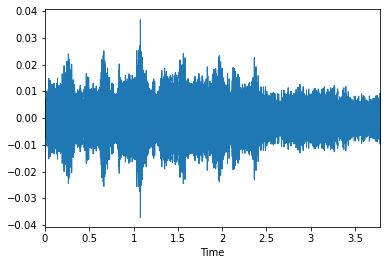

In [7]:
y_cut=y[int(round(tstart*sr)):int(round(tend*sr))]
librosa.display.waveplot(y_cut,sr=sr, x_axis='time', offset=0.0)
plt.show()

## A sample sounds like this:

In [8]:
ipd.Audio(y_cut, rate=sr) # load a NumPy array
wavfile.write('/kaggle/working/filename.wav', sr, y_cut)
Audio('/kaggle/working/filename.wav')

# Features for extraction:

## 1) Power spectrum

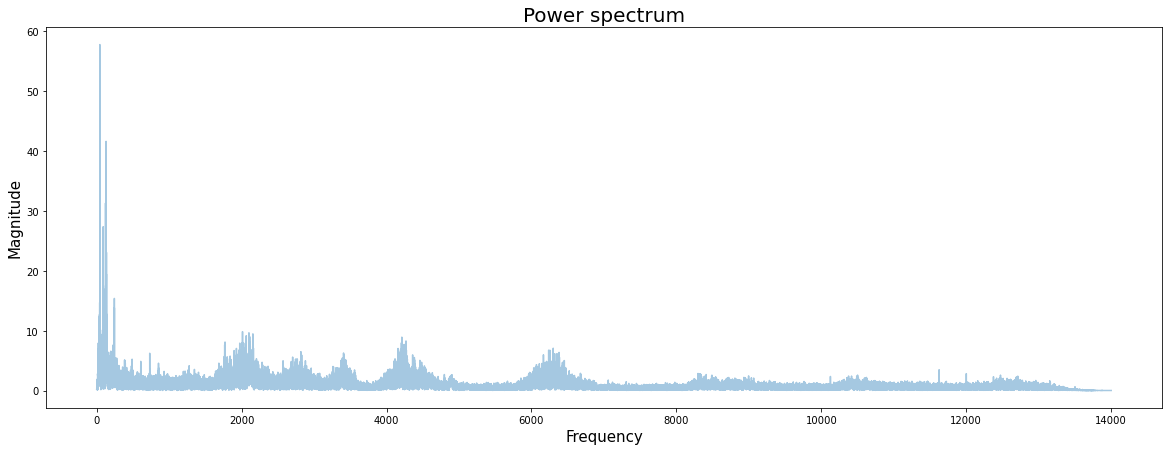

In [9]:
#FFT
fft = np.fft.fft(y_cut)
magnitude=np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))[:int(len(magnitude)/2)]
magnitude=magnitude[:int(len(magnitude)/2)]
# plot spectrum
plt.figure(figsize=(20,7))
plt.plot(frequency, magnitude, alpha=0.4)
plt.xlabel("Frequency",fontsize=15)
plt.ylabel("Magnitude",fontsize=15)
plt.title("Power spectrum",fontsize=20)
plt.show()

## 2) Spectrogram

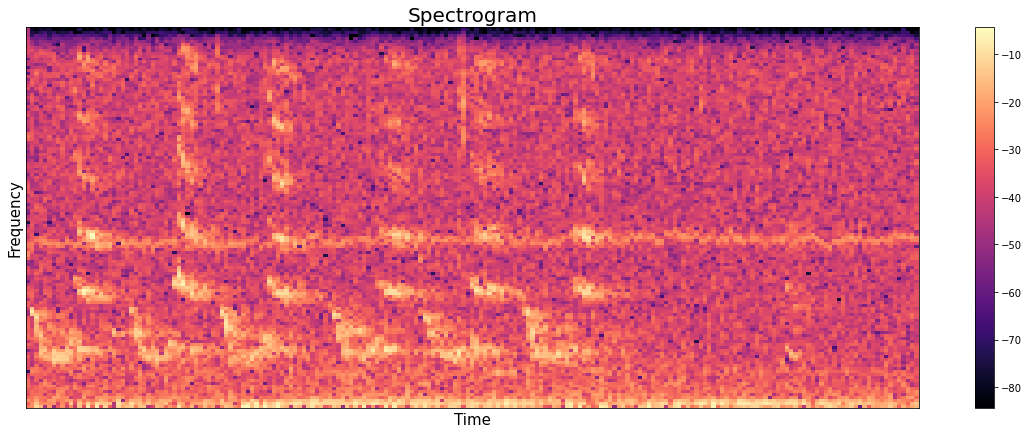

In [10]:
hop_length = 512 # in num. of samples
n_fft = 255 # window in num. of samples
# perform stft
stft = librosa.stft(y_cut, n_fft=n_fft, hop_length=hop_length)
# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=(20,7))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram),sr=sr, hop_length=hop_length)
plt.xlabel("Time", fontsize=15)
plt.xticks()
plt.ylabel("Frequency", fontsize=15)
plt.colorbar()
plt.title("Spectrogram", fontsize=20)
plt.show()

## 3) MFCC's

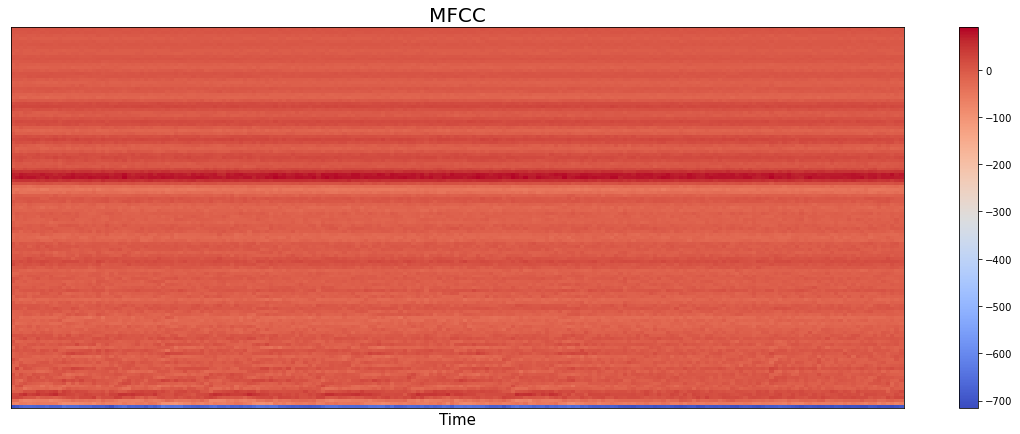

In [11]:
MFCCs = librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length,n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

## 4) Spectral centroid

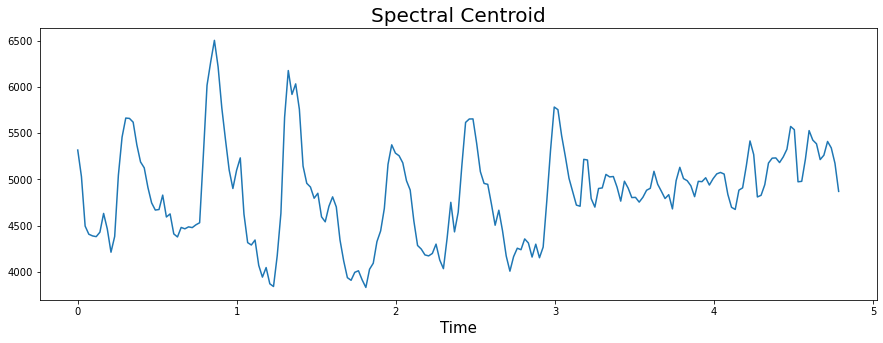

In [12]:
spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
fig, ax = plt.subplots(figsize=(15,5))
time = librosa.times_like(spec_centroid)
plt.plot(time,spec_centroid.T)
ax.set_xlabel('Time',fontsize=15)
ax.set_title('Spectral Centroid',size=20)
plt.show()

## 4) Chroma temperature:

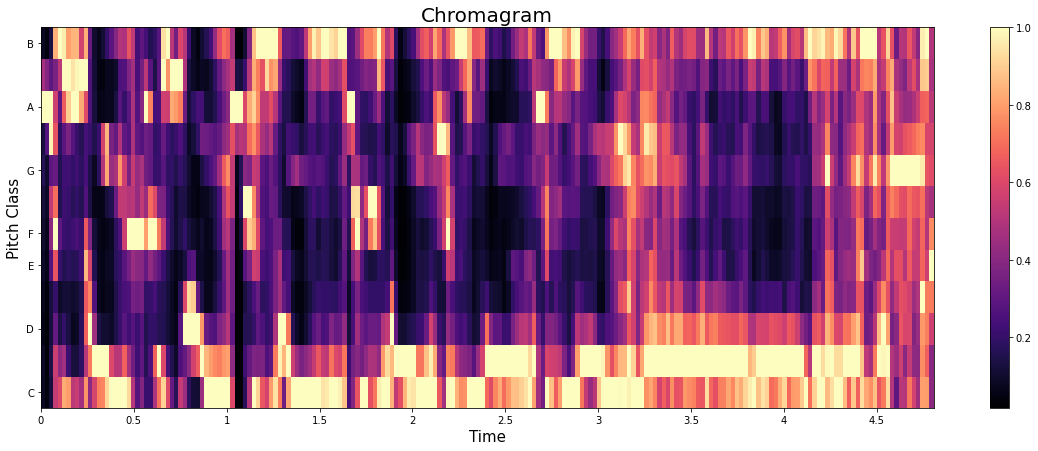

In [13]:
chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
img = librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=ax)
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Pitch Class', fontsize=15)
ax.set_title('Chromagram', size=20)
fig.colorbar(img, ax=ax)
plt.show()

## 5) Spectral bandwidth

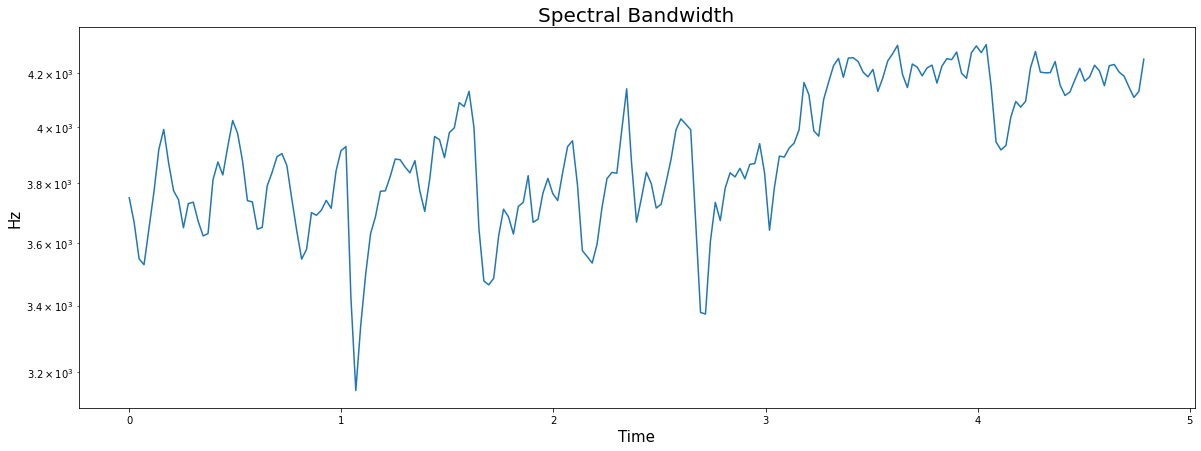

In [14]:
fig, ax = plt.subplots(figsize=(20,7))
spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
times = librosa.times_like(spec_bw)
ax.semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax.set_ylabel('Hz',fontsize=15)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('Spectral Bandwidth', size=20)
plt.show()

## 6) Spectral rolloff

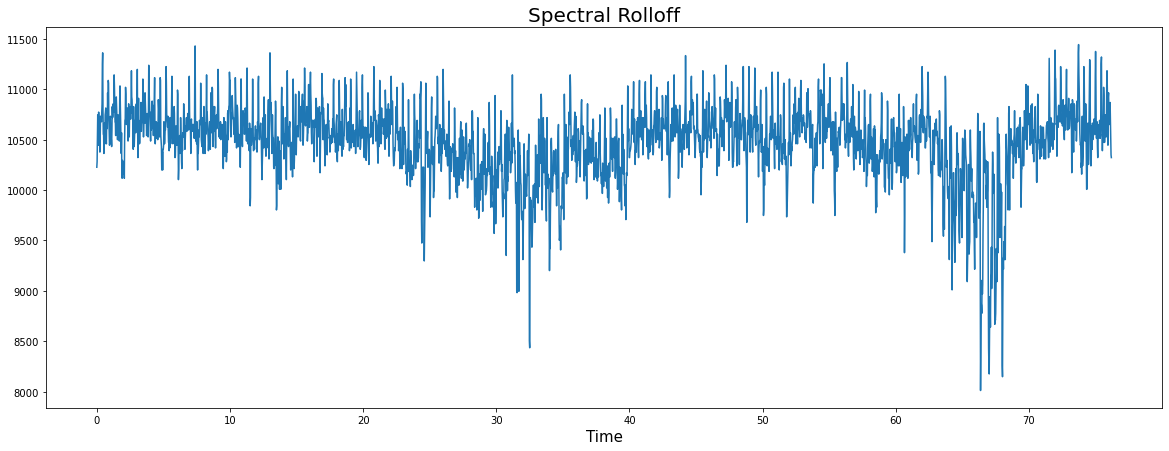

In [15]:
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
times = librosa.times_like(rolloff)
fig, ax = plt.subplots(figsize=(20,7))
plt.plot(times,rolloff[0])
ax.set_xlabel('Time', fontsize=15)
ax.set_title('Spectral Rolloff', fontsize=20)
plt.show()

# Shape the data into 4D structures suitable for CNN

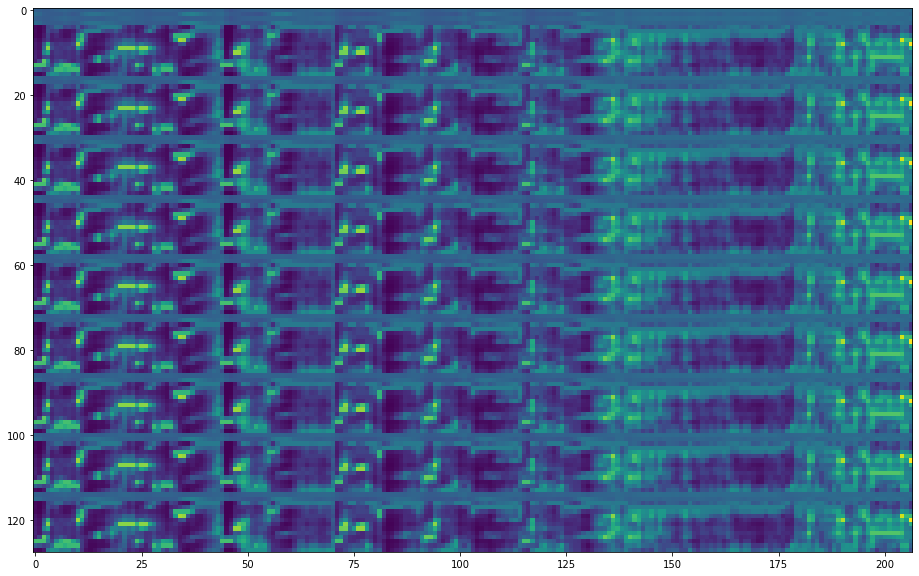

In [16]:
image=normalize(np.array([spec_bw]).reshape(1,207))
image = normalize(np.append(image,spec_centroid.reshape(1,207), axis=0))
for i in range(0,9):
        image = normalize(np.append(image, spec_bw.reshape(1,207), axis=0))
        image = normalize(np.append(image, spec_centroid.reshape(1,207), axis=0))
        image = normalize(np.append(image,chroma_stft.reshape(12,207), axis=0))
image.shape
fig, ax = plt.subplots(figsize=(22,10))
plt.imshow(image)
plt.show()

In [17]:
image=np.dstack((image,spectrogram.reshape(128,207)))
image=np.dstack((image,MFCCs.reshape(128,207)))
image.shape

(128, 207, 3)

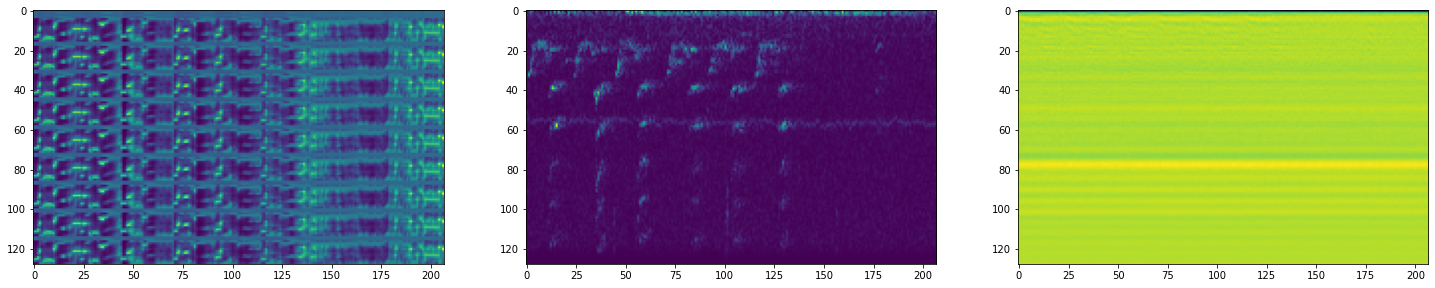

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,10))
ax1.imshow(image[:,:,0])
ax2.imshow(image[:,:,1])
ax3.imshow(image[:,:,2])
plt.show()

## Some species are undersampled with regard to the minority class:

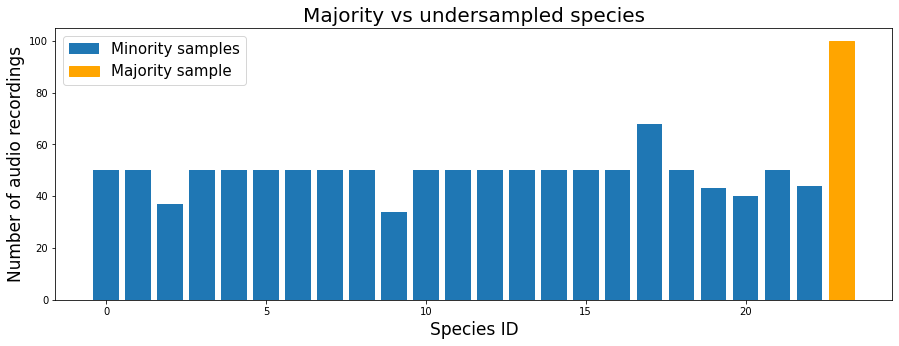

In [19]:
values = df.species_id.value_counts()
fig, ax = plt.subplots(figsize=(15,5))
barlist=plt.bar(values.index[1:],values[1:], label='Minority samples')
barlist=plt.bar(values.index[0],values.iloc[0], label='Majority sample')
plt.xlabel('Species ID', fontsize=17)
plt.ylabel('Number of audio recordings', fontsize=17)
plt.title('Majority vs undersampled species', fontsize=20)
barlist[0].set_color('orange')
plt.legend(fontsize=15)
plt.show()

# Augment the undersampled species randomly until enough samples have been generated in three ways: 
## <p> 1) adding noise to the signal, <p>2) including more time in the audio sample and <p>3) repeating the audio signal, <p>

## Extract background noise from signal prior to augmentation:

In [20]:
y_noise = y[:int(round(tstart*sr))] #noise before species time starts
ipd.Audio(y_noise[20*sr:24*sr], rate=sr) # the section that just has noise in it
wavfile.write('/kaggle/working/filename-noise.wav', sr, y_noise[20*sr:24*sr]) #this section is devoid of signal
Audio('/kaggle/working/filename-noise.wav')

## Create a noise dictionary to add to the signal during augmentation:

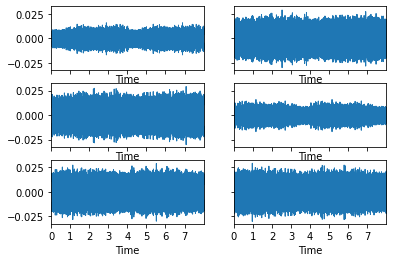

In [21]:
noise1 = np.concatenate((np.array(y_noise[20*sr:24*sr]),np.array(y_noise[20*sr:24*sr]))) #double it to 8 seconds length
#Augment the noise by adding random noise
noise2= noise1 + (0.005 * np.random.randn(len(noise1)))
#Subtract random noise to get a third type
noise3 = noise1 - (0.005 * np.random.randn(len(noise1)))
#Flip the noises to get three more:
noise4 = np.flip(noise1)
noise5 = np.flip(noise2)
noise6 = np.flip(noise3)
#place these noise types into a dictionary
noise_dict = {1:noise1,2:noise2,3:noise3,4:noise4,5:noise5,6:noise6}

fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
(ax1, ax2), (ax3,ax4), (ax5,ax6) = axs
img1=librosa.display.waveplot(noise1,sr=sr, x_axis='time', ax=ax1,offset=0.0)
img2=librosa.display.waveplot(noise2,sr=sr, x_axis='time', offset=0.0, ax=ax2)
img3=librosa.display.waveplot(noise3,sr=sr, x_axis='time', offset=0.0, ax=ax3)
img4=librosa.display.waveplot(noise4,sr=sr, x_axis='time', ax=ax4,offset=0.0)
img5=librosa.display.waveplot(noise5,sr=sr, x_axis='time', offset=0.0, ax=ax5)
img6=librosa.display.waveplot(noise6,sr=sr, x_axis='time', offset=0.0, ax=ax6)
plt.show()

## Create a function to generate features:

In [22]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)

    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [23]:
def generate_features(y_cut):#generate features for machine learning from signal
    max_size=1000
    fft = np.fft.fft(y_cut)
    mag=np.abs(fft)
    fft=fft[:int(len(mag)/2)]#save half of fft because it's a duplicate of the other half & leave off DC shift
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=255, hop_length=hop_length)),128,max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length,n_mfcc=128),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y_cut, sr=sr)
    image=np.array([padding(normalize(spec_bw),1,max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1,max_size), axis=0)
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1,max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1,max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12,max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

# Output of generate_features are 3D padded images of features 

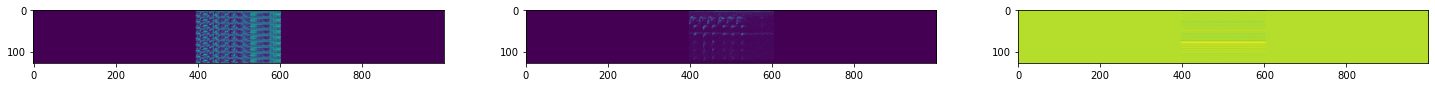

In [24]:
image = generate_features(y_cut)
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,10))
ax1.imshow(image[:,:,0])
ax2.imshow(image[:,:,1])
ax3.imshow(image[:,:,2])
plt.show()

## Create a function to generate minority oversampling for the training data

In [25]:
#Minority oversampling algorithm takes in a df of audio with columns=['recording_id','species_id','songtype_id', 
#'t_min', 'f_min', 't_max','f_max'], and an int MM of the number of desired copies and returns df of augmented features
def minority_oversample(MM,df_in): 
    #output = np.zeros((2400,128,1000,3)) #make an empty list to store the features
    features=[]
    labels = [] #empty array to store labels
    #For each species, determine how many augmentations are needed
    df_in=df_in.reset_index()
    for i in df_in.species_id.unique():
        print('species_id:',i)
        filelist = df_in.loc[df_in.species_id == i].index #all the file indices with the same species_id
        left_overs = MM % len(filelist) 
        for j in range(0,len(filelist)):
            num_iter = int(math.floor(MM/len(filelist)))-1
            loop=num_iter
            if(left_overs>0): loop = num_iter + 1
            stop = left_overs - 1
            filename = df_in.iloc[filelist[j]].recording_id +str('.flac') #get the filename
            tstart = df_in.iloc[filelist[j]].t_min #define the beginning time of the signal
            tend = df_in.iloc[filelist[j]].t_max #end of signal
            recording_id = df_in.iloc[filelist[j]].recording_id 
            species_id = i
            songtype_id = df_in.iloc[filelist[j]].songtype_id
            y, sr = librosa.load(filename,sr=28000) #Load the file
            y_cut=y[int(round(tstart*sr)):int(round(tend*sr))] #cut the file to signal start and end
            data = generate_features(y_cut) #generate features & output numpy array
            features.append(data[np.newaxis,...])
            labels.append(species_id)
            while(loop>0):
                num=np.random.randint(low=1, high=18) #generate a random number from 1-18
                if (num>= 1 and num <= 6):
                    #If 1-6 are generated, add the corresponding noise from the dictionary to the signal.
                    temp=noise_dict[num][0:len(y_cut)] + y_cut
                    data=generate_features(temp) #generate features for noise plus signal
                    features.append(data[np.newaxis,...])
                    labels.append(species_id)
                elif (num >6 and num <= 12): 
                    #If 7-12 are generated, increase the time of the audio to include before the tmin start time of the signal.
                    estart = max(0,tstart - 1) #start the time one second earlier
                    temp=y[int(round(estart*sr)):int(round(tend*sr))] 
                    data=generate_features(temp) #generate features for longer audio file
                    features.append(data[np.newaxis,...])
                    labels.append(species_id)
                else:
                    #If 13-18 are generated, double the signal to have it repeated twice.
                    temp=np.concatenate([y_cut,y_cut],axis=None) #double the audio signal
                    data=generate_features(temp)
                    features.append(data[np.newaxis,...])
                    labels.append(species_id)
                num_iter = num_iter - 1
                loop = loop - 1
                if num_iter < 0:
                    left_overs = left_overs - 1
    output=np.concatenate(features,axis=0)
    return(np.array(output), labels)

# Split the data into train and test

In [26]:
X=df.drop('species_id',axis=1)
y=df.species_id
#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((912, 6), (304, 6), (912,), (304,))

# Oversample the minority training true positives and write to file 
## Note that memory constraints during deep learning prevent from upsampling to an ideal max(y_train.value_counts()) and is instead restricted to 50 samples.

In [27]:
#Oversample the true positives training dataset, extract features and write to file
train_features, train_labels = minority_oversample(50,pd.concat([X_train,y_train],axis=1)) #sample to 50 species
print(train_features.shape,len(train_labels))
joblib.dump(train_features, '/kaggle/working/train_features.pkl')
joblib.dump(train_labels, '/kaggle/working/train_labels.pkl')

species_id: 22
species_id: 12
species_id: 19
species_id: 16
species_id: 23
species_id: 8
species_id: 20
species_id: 6
species_id: 7
species_id: 14
species_id: 17
species_id: 3
species_id: 1
species_id: 18
species_id: 21
species_id: 4
species_id: 10
species_id: 11
species_id: 0
species_id: 15
species_id: 5
species_id: 9
species_id: 13
species_id: 2
(1226, 128, 1000, 3) 1226


['/kaggle/working/train_labels.pkl']

# Extract features for the test dataset

In [28]:
def get_features_noOS(df_in): #no oversampling
    features=[]
    labels = [] #empty array to store labels
    #For each species, determine how many augmentations are needed
    df_in=df_in.reset_index()
    for i in df_in.species_id.unique():
        print('species_id:',i)
        filelist = df_in.loc[df_in.species_id == i].index #all the file indices with the same species_id
        for j in range(0,len(filelist)):
            filename = df_in.iloc[filelist[j]].recording_id +str('.flac') #get the filename
            tstart = df_in.iloc[filelist[j]].t_min #define the beginning time of the signal
            tend = df_in.iloc[filelist[j]].t_max #end of signal
            recording_id = df_in.iloc[filelist[j]].recording_id 
            species_id = i
            songtype_id = df_in.iloc[filelist[j]].songtype_id
            y, sr = librosa.load(filename,sr=28000) #Load the file
            y_cut=y[int(round(tstart*sr)):int(round(tend*sr))] #cut the file to signal start and end
            data = generate_features(y_cut) #generate features & output numpy array
            features.append(data[np.newaxis,...])
            labels.append(species_id)
    output=np.concatenate(features,axis=0)
    return(np.array(output), labels)

# Extract features for the test set and write to file

In [29]:
test_features, test_labels = get_features_noOS(pd.concat([X_test,y_test],axis=1))
print(test_features.shape,len(test_labels))
joblib.dump(test_features, '/kaggle/working/test_features.pkl')
joblib.dump(test_labels, '/kaggle/working/test_labels.pkl')

species_id: 15
species_id: 17
species_id: 14
species_id: 13
species_id: 22
species_id: 18
species_id: 0
species_id: 6
species_id: 23
species_id: 3
species_id: 4
species_id: 16
species_id: 10
species_id: 19
species_id: 2
species_id: 7
species_id: 5
species_id: 1
species_id: 8
species_id: 20
species_id: 21
species_id: 12
species_id: 11
species_id: 9
(304, 128, 1000, 3) 304


['/kaggle/working/test_labels.pkl']

# Compare against modeling without augmenting training data

In [30]:
train_noOS_features, train_noOS_labels = get_features_noOS(pd.concat([X_train,y_train],axis=1))
print(train_noOS_features.shape,len(train_noOS_labels))
joblib.dump(train_noOS_features, '/kaggle/working/train_noOS_features.pkl')
joblib.dump(train_noOS_labels, '/kaggle/working/train_noOS_labels.pkl')

species_id: 22
species_id: 12
species_id: 19
species_id: 16
species_id: 23
species_id: 8
species_id: 20
species_id: 6
species_id: 7
species_id: 14
species_id: 17
species_id: 3
species_id: 1
species_id: 18
species_id: 21
species_id: 4
species_id: 10
species_id: 11
species_id: 0
species_id: 15
species_id: 5
species_id: 9
species_id: 13
species_id: 2
(912, 128, 1000, 3) 912


['/kaggle/working/train_noOS_labels.pkl']